In [1]:
#id-2 - [1,0], id_7 - [0,1]
import tensorflow as tf 

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [134]:
data_x, data_y = [], []
num_class = 2
img_h=250
img_w=250
img_c=3
img_length = 250*250*3

id_list = [6,8]

for i in range(len(id_list)):
    part_x, part_y = [], []
    folder = '../pixiv/quar_'+str(id_list[i])
    for img_file in os.listdir(folder):
#         print(folder+'/'+img_file)
        img = np.array(Image.open(folder+'/'+img_file))
#         img = np.reshape(img, len(img)*len(img[0])*len(img[0][0]))
        part_x.append(img/255.0)
        
        label = [0 for j in range(0, num_class)]
        label[i]=1
        part_y.append(label)   
        if(len(part_x)>=3800):
            break
    print(len(part_x))
    data_x.extend(part_x)
    data_y.extend(part_y)
    print(folder+' is completed.')

print(len(data_x))
print(len(data_y))

798
../pixiv/quar_6 is completed.
594
../pixiv/quar_8 is completed.
1392
1392


In [135]:
data_x = np.array(data_x, dtype='float32')
data_y = np.array(data_y, dtype='float32')

print(data_x[:3])
print(data_y[:3])

[[[[ 0.74509805  0.69411767  0.76078433]
   [ 0.72941178  0.67843139  0.74509805]
   [ 0.73333335  0.68235296  0.74901962]
   ..., 
   [ 0.52156866  0.44313726  0.41568628]
   [ 0.7764706   0.7019608   0.67450982]
   [ 0.96078432  0.88627452  0.85882354]]

  [[ 0.74901962  0.69803923  0.7647059 ]
   [ 0.72941178  0.67843139  0.74509805]
   [ 0.72549021  0.67450982  0.74117649]
   ..., 
   [ 0.49019608  0.41568628  0.3882353 ]
   [ 0.5529412   0.47843137  0.4509804 ]
   [ 0.85882354  0.78431374  0.75686276]]

  [[ 0.75294119  0.7019608   0.76862746]
   [ 0.73333335  0.68235296  0.74901962]
   [ 0.72156864  0.67058825  0.73725492]
   ..., 
   [ 0.46666667  0.39215687  0.36862746]
   [ 0.48235294  0.40784314  0.38431373]
   [ 0.6901961   0.62352943  0.59607846]]

  ..., 
  [[ 0.41960785  0.39607844  0.41176471]
   [ 0.39215687  0.36862746  0.38431373]
   [ 0.35686275  0.33333334  0.34901962]
   ..., 
   [ 0.79215688  0.7764706   0.78039217]
   [ 0.78431374  0.76862746  0.77254903]
   [ 0.

In [136]:
order = [i for i in range(len(data_x))]
random.shuffle(order)

print(len(order))
n=int(len(data_x)*9/10)
print(n)

train_x = [data_x[i] for i in order[0:n]]
train_y = [data_y[i] for i in order[0:n]]

test_x = [data_x[i] for i in order[n:]]
test_y = [data_y[i] for i in order[n:]]

print(len(train_x))
print(len(test_y))

1392
1252
1252
140


In [137]:
learning_rate=0.005

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    is_training=True

    def tf_variable(shape, name=None):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

    def dense_connect(x, shape):
        w = tf_variable(shape)
        b = tf.Variable(tf.zeros([shape[1]]))
        return tf.matmul(x, w) + b

    def batch_norm(inputs, is_training,is_conv_out=True,decay = 0.999):
        scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
        beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
        pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
        pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)
        if is_training:
            if is_conv_out:
                batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
            else:
                batch_mean, batch_var = tf.nn.moments(inputs,[0])   

            train_mean = tf.assign(pop_mean,
                                   pop_mean * decay + batch_mean * (1 - decay))
            train_var = tf.assign(pop_var,
                                  pop_var * decay + batch_var * (1 - decay))
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                    batch_mean, batch_var, beta, scale, 0.001)
        else:
            return tf.nn.batch_normalization(inputs,
                pop_mean, pop_var, beta, scale, 0.001)

    def conv2d_with_batch_norm(x, filter_shape, stride):
        filter_ = tf_variable(filter_shape)
        conv = tf.nn.conv2d(x, filter=filter_, strides=[1, stride, stride, 1], padding="SAME")
        normed=batch_norm(conv, is_training)
        return  tf.nn.relu(normed)


    def conv2d(x, filter_shape, stride):
        out_channels = filter_shape[3]
        conv = tf.nn.conv2d(x, filter=tf_variable(filter_shape), strides=[1, stride, stride, 1], padding="SAME")
        bias = tf.Variable(tf.zeros([out_channels]), name="bias")
        return tf.nn.relu(tf.nn.bias_add(conv,bias))


    def max_pool(x):
        return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    def residual_block(x, out_channels, down_sample, projection=False):
        in_channels = x.get_shape().as_list()[3]
        if down_sample:
            x = max_pool(x)

        output = conv2d_with_batch_norm(x, [3, 3, in_channels, out_channels], 1)
        output = conv2d_with_batch_norm(output, [3, 3, out_channels, out_channels], 1)

        if in_channels != out_channels:
            if projection:
                # projection shortcut
                input_ = conv2d(x, [1, 1, in_channels, out_channels], 2)
            else:
                # zero-padding
                input_ = tf.pad(x, [[0,0], [0,0], [0,0], [0, out_channels - in_channels]])
        else:
            input_ = x

        return output + input_


    def residual_group(name,x,num_block,out_channels):
        assert num_block>=1,'num_block must greater than 1'
        with tf.variable_scope('%s_head'%name):
            output = residual_block(x, out_channels, True)
        for i in range (num_block-1):
            with tf.variable_scope('%s_%d' % (name,i+1)):
                output = residual_block(output,out_channels, False)
        return output


    def residual_net(inpt):
        with tf.variable_scope('conv1'):
            output = conv2d(inpt, [3, 3, 3, 16], 1)
            print(output.shape)
        output=residual_group('conv2', x=output,num_block=2,out_channels=16)
        print(output.shape)
        output=residual_group('conv3', x=output,num_block=2,out_channels=32)
        print(output.shape)
        output=residual_group('conv4', x=output,num_block=2,out_channels=64)
        print(output.shape)
        with tf.variable_scope('fc'):
            output=max_pool(output)
            print(output.shape)
            shape=output.get_shape().as_list()
            i_shape=shape[1]*shape[2]*shape[3]
            print(i_shape)
            output=tf.reshape(output,[-1,i_shape])
            print(output.shape)
            return dense_connect(output, [i_shape, num_class])

    x = tf.placeholder("float", [None, img_h, img_w, img_c])#[batch_size,width,height,channels]
    y = tf.placeholder("float", [None, num_class])#[batch_size,num_classes]

#     x_image = tf.reshape(x, [-1,250,250,3])
    pred = residual_net(x)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
#     accuracyte = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 250, 250, 16)
(?, 125, 125, 16)
(?, 63, 63, 32)
(?, 32, 32, 64)
(?, 16, 16, 64)
16384
(?, 16384)


In [138]:
batch_size = 256
training_iters=101
batch_start=0

train_accur = []
train_loss = []
test_accur = []
test_loss = []

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    step = 1
    print('Initialized')
    for step in range(training_iters): 
        if(batch_start+batch_size>=len(train_x)): 
            order = [i for i in range(len(train_x))]
            random.shuffle(order)
            train_x = [train_x[i] for i in order]
            train_y = [train_y[i] for i in order]
            batch_start = 0   
        feed_x = train_x[batch_start:batch_start+batch_size]
        feed_y = train_y[batch_start:batch_start+batch_size]
        
#         sess.run(optimizer, feed_dict={inputs: feed_x, labels: feed_y})
        _, l, accur = sess.run([optimizer, cost, accuracy], feed_dict = {x: feed_x, y: feed_y})
        if(step % 5 == 0):
            train_accur.append(accur)
            train_loss.append(l)
            print('Loss at step %d: %f' % (step, l))
            print('accuarcy is ', accur)
            
            test_l, test_a = sess.run([cost, accuracy], feed_dict={x: test_x, y: test_y})
            test_loss.append(test_l)
            test_accur.append(test_a)
            print('test loss, ', test_l, ' test accur is ', test_a)
            
print("train finished")

Initialized
Loss at step 0: 17.055685
accuarcy is  0.617188
test loss,  204.429  test accur is  0.371429
Loss at step 5: 20.744234
accuarcy is  0.761719
test loss,  21.1685  test accur is  0.785714
Loss at step 10: 8.015167
accuarcy is  0.859375
test loss,  7.53504  test accur is  0.885714
Loss at step 15: 5.120030
accuarcy is  0.871094
test loss,  7.0515  test accur is  0.807143
Loss at step 20: 2.544648
accuarcy is  0.898438
test loss,  3.07619  test accur is  0.835714
Loss at step 25: 1.354263
accuarcy is  0.890625
test loss,  1.61943  test accur is  0.871429
Loss at step 30: 0.687590
accuarcy is  0.863281
test loss,  1.05897  test accur is  0.857143
Loss at step 35: 0.453959
accuarcy is  0.898438
test loss,  1.57799  test accur is  0.735714
Loss at step 40: 0.274807
accuarcy is  0.925781
test loss,  1.23244  test accur is  0.771429
Loss at step 45: 0.215428
accuarcy is  0.929688
test loss,  1.02717  test accur is  0.828571
Loss at step 50: 0.151573
accuarcy is  0.960938
test loss, 

In [11]:
import matplotlib.pyplot as plt

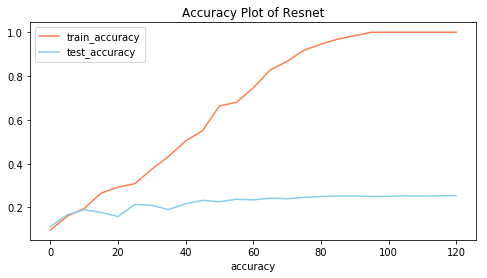

In [38]:
plt.figure(figsize=(8, 4))
plt.title("Accuracy Plot of Resnet")
plt.xlabel('training steps')
plt.xlabel('accuracy')
plt.plot([i*5 for i in range(25)], [i for i in train_accur[:25]], 'coral', label = 'train_accuracy')
plt.plot([i*5 for i in range(25)], [i for i in test_accur[:25]], 'skyblue', label = 'test_accuracy')
plt.legend()
plt.show()